In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense
import sys
from keras.callbacks import EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input, GRU, TimeDistributed, Dense, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, TimeDistributed, Dense, Dropout, Reshape, Attention, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, GRU, TimeDistributed, Dense, Dropout, Reshape, Flatten, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

In [2]:
from tensorflow.keras.layers import Input, GRU, TimeDistributed, Dense, Dropout, Attention, Concatenate, Flatten
from tensorflow.keras.regularizers import l2
import pickle

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
with open('Extracted_Features/Final_Arousal_Features.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    final_arousal_df = pickle.load(f)

In [5]:
with open('Extracted_Features/Final_Valence_Features.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    final_valence_df = pickle.load(f)

In [6]:
final_valence_df.drop(["Arousal","Gender", "participant", "video", "Video_Name", "Age"], inplace=True, axis=1)
final_arousal_df.drop(["Valence", "Gender", "participant", "video", "Video_Name", "Age"], inplace=True, axis=1)

## Random Forest Regressor

### For Valence

In [7]:
X = final_valence_df.drop(columns=['Valence', 'Target_Emotion'])  # Drop the target columns
y = final_valence_df['Valence']  # Target column

In [8]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training with Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

ValueError: setting an array element with a sequence.

In [26]:
# Predictions and evaluation
y_pred = model.predict(X_test)

In [27]:
mse = mean_squared_error(y_test, y_pred)

In [28]:
r2 = r2_score(y_test, y_pred)

In [29]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 1.8003421686746985
R^2 Score: -0.03752360716078251


### For Emotion Classification

In [9]:
X = final_valence_df.drop(columns=['Valence', 'Target_Emotion'])  # Drop the target columns
y = final_valence_df['Target_Emotion']  # Target column

In [10]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Model training with Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

NameError: name 'X_flattened' is not defined

## Using Conv1D 

In [16]:
# Splitting the features (X) and target (y)
X = final_valence_df.drop(columns=['Valence', 'Target_Emotion'])  # Drop the target columns
y = final_valence_df['Valence']  # Target column

In [21]:
len(final_valence_df.columns)

158

In [20]:
list_columns = [col for col in final_valence_df.columns if isinstance(final_valence_df[col].iloc[0], list)]
len(list_columns)

140

In [22]:
def list_len(x):
    if isinstance(x, list):
        return len(x)
    else:
        return 0  # Or any other default value

In [23]:
max_length = final_valence_df[list_columns].applymap(list_len).max().max()
print("Maximum length of lists:", max_length)

Maximum length of lists: 640


/tmp/ipykernel_5334/1240711617.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_length = final_valence_df[list_columns].applymap(list_len).max().max()


In [24]:
def pad_list(lst, max_length):
    return np.pad(lst, (0, max_length - len(lst)), 'constant')

for col in list_columns:
    final_valence_df[col] = final_valence_df[col].apply(lambda x: pad_list(x, max_length))

In [25]:
def convert_to_3d_array(df, columns):
    return np.stack(df[columns].apply(lambda row: np.stack(row.values), axis=1).values)

# Prepare the data
X = convert_to_3d_array(final_valence_df, list_columns)
y = final_valence_df['Valence'].values

In [26]:
print(X.shape)  # Should be (number_of_samples, number_of_columns, max_length)
print(y.shape)  # Should be (number_of_samples,)

(414, 140, 640)
(414,)


In [28]:
def get_model(num_time_steps, num_features, _rnn_nb, _fc_nb, dropout_rate=0.5, l2_reg=1e-4):
    spec_start = Input((num_time_steps, num_features))

    spec_x = spec_start

    for _r in _rnn_nb:
        spec_x = GRU(_r, activation='tanh', dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True, kernel_regularizer=l2(l2_reg))(spec_x)
        spec_x = Dropout(dropout_rate)(spec_x)

    attention = Attention()([spec_x, spec_x])

    attended = Attention()([spec_x, attention])

    spec_x = Concatenate(axis=-1)([spec_x, attended])

    for _f in _fc_nb:
        spec_x = TimeDistributed(Dense(_f, activation='relu', kernel_regularizer=l2(l2_reg)))(spec_x)
        spec_x = Dropout(dropout_rate)(spec_x)

    out = TimeDistributed(Dense(1, activation='linear'))(spec_x)
    out = Flatten()(out)
    out = Dense(1, activation='linear')(out)

    _model = Model(inputs=spec_start, outputs=out)
    _model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    _model.summary()

    return _model


In [29]:
# Example usage
num_time_steps = len(list_columns)  # Number of feature columns
num_features = max_length  # Length of each list after padding
model = get_model(num_time_steps, num_features, _rnn_nb=[64, 128], _fc_nb=[64])

# Train the model
model.fit(X, y, epochs=10, batch_size=32)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 140, 640)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 140, 64)   │    135,552 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 140, 64)   │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 140, 128)  │     74,496 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 140, 128)  │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 140, 128)  │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 140, 128)  │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 140, 256)  │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 140, 64)   │     16,448 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 140, 64)   │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 140, 1)    │         65 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 140)       │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        141 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 226,702 (885.55 KB)

 Trainable params: 226,702 (885.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-07-12 14:34:22.328973: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 148377600 exceeds 10% of free system memory.


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 360ms/step - loss: nan - mean_squared_error: nan
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - loss: nan - mean_squared_error: nan
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - loss: nan - mean_squared_error: nan
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - loss: nan - mean_squared_error: nan
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - loss: nan - mean_squared_error: nan
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - loss: nan - mean_squared_error: nan
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - loss: nan - mean_squared_error: nan
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - loss: nan - mean_squared_error: nan
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - loss: nan - mean_squared_error: nan
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - loss: nan - mean_squared_error: nan


## Using ML models and CNN model - working

In [87]:
from tensorflow.keras.utils import to_categorical

In [88]:
import pickle
import pandas as pd

with open('./Extracted_Features/Final_Valence_Features.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    final_df = pickle.load(f)

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Assuming 'final_df' is already loaded

# Define the target variable
target = 'Target_Emotion'

# Extract DWT features
dwt_features = [col for col in final_df.columns if col.endswith(('_alpha', '_beta', '_gamma', '_theta'))]

# Extract IMF features
imf_features = [col for col in final_df.columns if col.endswith(tuple([f'_IMF_{i}' for i in range(1, 7)]))]


In [90]:
# Encode the target variable
label_encoder = LabelEncoder()
final_df[target] = label_encoder.fit_transform(final_df[target])

In [91]:
# Prepare the data for DWT model
X_dwt = final_df[dwt_features]
y_dwt = final_df[target]

# Prepare the data for IMF model
X_imf = final_df[imf_features]
y_imf = final_df[target]

In [92]:
len(X_imf.columns)

84

In [93]:
X = X_imf
y = y_imf

In [8]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Sample data creation for illustration
# X_imf should be replaced with your actual dataframe
# Assuming X_imf is a dataframe with lists of 7680 elements

# Function to flatten columns containing lists into a 2D array
def flatten_columns(df):
    return np.array(df.iloc[:, :len(df.columns)].values.tolist()).reshape(df.shape[0], -1)

flattened_data = flatten_columns(X)

# Verify the shape of the flattened data
print(f'Flattened data shape: {flattened_data.shape}')


Flattened data shape: (414, 645120)


In [9]:
standardized_data = flattened_data

#### Random Forest Classifier - doesn't run

In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(standardized_data, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
classifier = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f'Best parameters found: {grid_search.best_params_}')

# Train the model with the best parameters
best_classifier = grid_search.best_estimator_
best_classifier.fit(X_train, y_train)

# Predict on test data
y_pred = best_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 

In [95]:
import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A2000 12GB
Memory Usage:
Allocated: 9.5 GB
Cached:    13.2 GB


In [96]:
y_one_hot = np.eye(9)[y]

### Todo: actually standardize the data instead of directly giving the flattened_data as input
#### If required maybe try with PCA

In [13]:
# Standardize the flattened data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(flattened_data)

# Verify the shape and mean/std of standardized data
print(f'Standardized data shape: {standardized_data.shape}')
print(f'Mean of standardized data: {np.mean(standardized_data, axis=0)}')
print(f'Standard deviation of standardized data: {np.std(standardized_data, axis=0)}')

Standardized data shape: (414, 645120)
Mean of standardized data: [ 2.54426110e-17 -1.30732784e-18  6.13438447e-18 ... -4.34770309e-17
  2.98338917e-18 -5.19076194e-17]
Standard deviation of standardized data: [1. 1. 1. ... 1. 1. 1.]


In [14]:
# standardized_data = flattened_data
standardized_data.shape

(414, 645120)

In [15]:
standardized_data = torch.tensor(standardized_data, dtype=torch.float32)
# y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

In [16]:
standardized_data.shape

torch.Size([414, 645120])

In [18]:
# Assuming imf_data is a 2D array with shape (num_samples, 480 * 1344)
imf_data = flattened_data.reshape(-1, 480, 1344)

# Standardize the reshaped imf_data
mean = np.mean(imf_data, axis=(1, 2), keepdims=True)
std = np.std(imf_data, axis=(1, 2), keepdims=True)
standardized_data = (imf_data - mean) / std

# print(mean)
# print(std)

In [19]:
standardized_data

array([[[-3.14285791e-02, -9.20818087e-03,  9.57107101e-04, ...,
         -3.83366686e-03, -1.81870793e-02, -4.25896066e-03],
        [ 8.81835499e-03, -4.38215242e-03, -1.78676451e-02, ...,
         -4.33882614e-03,  5.99797174e-03, -1.16609015e-03],
        [-1.54028476e-02, -1.54133683e-02, -9.49912479e-04, ...,
         -5.25398297e-03, -1.66127335e-02, -9.42453598e-03],
        ...,
        [ 3.40660250e-02,  3.75104981e-02,  4.05853182e-02, ...,
         -2.76282933e-02, -3.16879660e-02, -3.55028474e-02],
        [-3.90182830e-02, -4.21775001e-02, -4.49213103e-02, ...,
          4.10069033e-02,  4.02491925e-02,  3.94094679e-02],
        [ 3.84925122e-02,  3.75031079e-02,  3.64460373e-02, ...,
          1.00913464e+01,  1.02461678e+01,  1.04025547e+01]],

       [[ 5.90709983e-03,  2.20047229e-02,  1.13996116e-02, ...,
         -3.99006010e-03, -2.28751864e-02, -7.95115460e-03],
        [ 1.81754181e-02,  1.45953765e-02, -1.17362244e-02, ...,
         -1.17520268e-02, -2.36947974e

In [20]:
standardized_data = standardized_data.reshape(standardized_data.shape[0], -1)

In [21]:
standardized_data.shape

(414, 645120)

In [28]:
X.shape

(414, 84)

### Correct code for standardization

In [98]:
num_samples = X.shape[0]
num_features = X.shape[1]
list_length = len(X.iloc[0, 0])

# Initialize a 3D NumPy array
X_3d = np.zeros((num_samples, num_features, list_length))

# Fill the 3D array with data from the DataFrame
for i in range(num_samples):
    for j in range(num_features):
        X_3d[i, j, :] = X.iloc[i, j]
print("Shape of X_3d:", X_3d.shape)

Shape of X_3d: (414, 84, 7680)


In [103]:
len(X_3d[0,0])

7680

In [104]:
# Convert the reshaped NumPy array to a PyTorch tensor
standardized_data = torch.tensor(X_3d, dtype=torch.float32)

### There is no need to run the below cells for standardization

In [15]:
# Standardize each feature (each sub-list independently)
scalers = []
data_standardized = np.zeros_like(X_3d)

for i in range(num_features):  # Iterate over features
    for j in range(list_length):  # Iterate over the list length
        scaler = StandardScaler()
        data_standardized[:, i, j] = scaler.fit_transform(X_3d[:, i, j].reshape(-1, 1)).flatten()
        scalers.append(scaler)

print("Shape of data_standardized:", data_standardized.shape)


Shape of data_standardized: (414, 84, 7680)


In [16]:
# Flatten the standardized data to 2D array
standardized_data = data_standardized.reshape(num_samples, -1)

print("Shape of standardized_flattened_data:", standardized_data.shape)

Shape of standardized_flattened_data: (414, 645120)


In [17]:
# Convert to PyTorch tensor
standardized_data = torch.tensor(standardized_data, dtype=torch.float32)

In [18]:
standardized_data

tensor([[-0.0402, -0.0142,  0.0117,  ...,  0.0693,  0.0695,  0.0697],
        [-0.0016,  0.0111,  0.0142,  ...,  0.0307,  0.0306,  0.0304],
        [ 0.0005, -0.0130, -0.0172,  ...,  0.0361,  0.0359,  0.0357],
        ...,
        [-0.0636, -0.0419, -0.0035,  ...,  0.0599,  0.0600,  0.0601],
        [-0.0586, -0.0385, -0.0092,  ...,  0.0477,  0.0477,  0.0476],
        [-0.0661, -0.0552, -0.0354,  ...,  0.0428,  0.0427,  0.0425]])

In [19]:
standardized_data = standardized_data.view(-1, 1, 480, 1344)


### Storing the best model

In [106]:
print(y_one_hot.shape)
y_one_hot

(414, 9)


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [107]:
y_one_hot_tensor = torch.tensor(y_one_hot)
print(y_one_hot_tensor.shape)
y_one_hot_tensor

torch.Size([414, 9])


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [108]:
y_one_hot = y_one_hot_tensor

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# Assuming standardized_data and y_one_hot are already defined
# Convert standardized_data and y_one_hot to PyTorch tensors
# standardized_data = torch.tensor(standardized_data, dtype=torch.float32)
# y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

# Reshape standardized_data to fit the CNN input requirements
# Reshape each sample to 2D (e.g., 480x1344)
# standardized_data = standardized_data.view(-1, 1, 480, 1344)

# Convert y_one_hot to class indices
y_indices = torch.argmax(y_one_hot, dim=1)

# Create a dataset and split it into training and testing sets
dataset = TensorDataset(standardized_data, y_indices)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 120 * 336, 128)  # Updated input size
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 9)  # Assuming y is one-hot encoded with 9 classes
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 120 * 336)  # Updated view size
        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

model = CNNModel()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Further reduced learning rate and added L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR by half every 5 epochs

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Path to save the best model
model_path = './Models/best_model.pth'

# Load the best model parameters if available
try:
    load_model(model, model_path)
    print("Loaded the best model parameters.")
except FileNotFoundError:
    print("No saved model found. Starting training from scratch.")

# Train the model
num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_x)
        
        # Compute the loss
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Step the scheduler
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')
    
    # Evaluate the model on the test set
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            predicted_classes = torch.argmax(outputs, dim=1)
            correct_predictions += (predicted_classes == batch_y).sum().item()
            total_predictions += batch_x.size(0)
    
    accuracy = correct_predictions / total_predictions * 100
    print(f"Accuracy on test set: {accuracy:.2f}%")
    
    # Save the model if it has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        save_model(model, model_path)
        print("Saved the best model parameters.")

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\1385617319.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Loaded the best model parameters.
Epoch [1/20], Loss: 1.9674
Accuracy on test set: 53.01%
Saved the best model parameters.
Epoch [2/20], Loss: 1.8193
Accuracy on test set: 46.99%
Epoch [3/20], Loss: 1.7001
Accuracy on test set: 53.01%
Epoch [4/20], Loss: 1.5849
Accuracy on test set: 69.88%
Saved the best model parameters.
Epoch [5/20], Loss: 1.4314
Accuracy on test set: 61.45%
Epoch [6/20], Loss: 1.3666
Accuracy on test set: 66.27%
Epoch [7/20], Loss: 1.2555
Accuracy on test set: 49.40%
Epoch [8/20], Loss: 1.2036
Accuracy on test set: 45.78%
Epoch [9/20], Loss: 1.0853
Accuracy on test set: 71.08%
Saved the best model parameters.
Epoch [10/20], Loss: 1.0539
Accuracy on test set: 60.24%
Epoch [11/20], Loss: 1.0039
Accuracy on test set: 69.88%
Epoch [12/20], Loss: 0.9066
Accuracy on test set: 69.88%
Epoch [13/20], Loss: 0.9255
Accuracy on test set: 69.88%
Epoch [14/20], Loss: 0.8829
Accuracy on test set: 69.88%
Epoch [15/20], Loss: 0.8493
Accuracy on test set: 71.08%
Epoch [16/20], Loss: 

### To check if the model is overfitting or underfitting - Visualisation

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\1993488471.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Loaded the best model parameters.
Epoch [1/20], Loss: 0.9226
Accuracy on test set: 74.70%
Saved the best model parameters.
Epoch [2/20], Loss: 0.8658
Accuracy on test set: 83.13%
Saved the best model parameters.
Epoch [3/20], Loss: 0.7320
Accuracy on test set: 93.98%
Saved the best model parameters.
Epoch [4/20], Loss: 0.6738
Accuracy on test set: 93.98%
Epoch [5/20], Loss: 0.5753
Accuracy on test set: 89.16%
Epoch [6/20], Loss: 0.5235
Accuracy on test set: 91.57%
Epoch [7/20], Loss: 0.4850
Accuracy on test set: 93.98%
Epoch [8/20], Loss: 0.4939
Accuracy on test set: 91.57%
Epoch [9/20], Loss: 0.4383
Accuracy on test set: 90.36%
Epoch [10/20], Loss: 0.4091
Accuracy on test set: 91.57%
Epoch [11/20], Loss: 0.3864
Accuracy on test set: 90.36%
Epoch [12/20], Loss: 0.3822
Accuracy on test set: 95.18%
Saved the best model parameters.
Epoch [13/20], Loss: 0.3436
Accuracy on test set: 95.18%
Epoch [14/20], Loss: 0.3226
Accuracy on test set: 92.77%
Epoch [15/20], Loss: 0.2940
Accuracy on test 

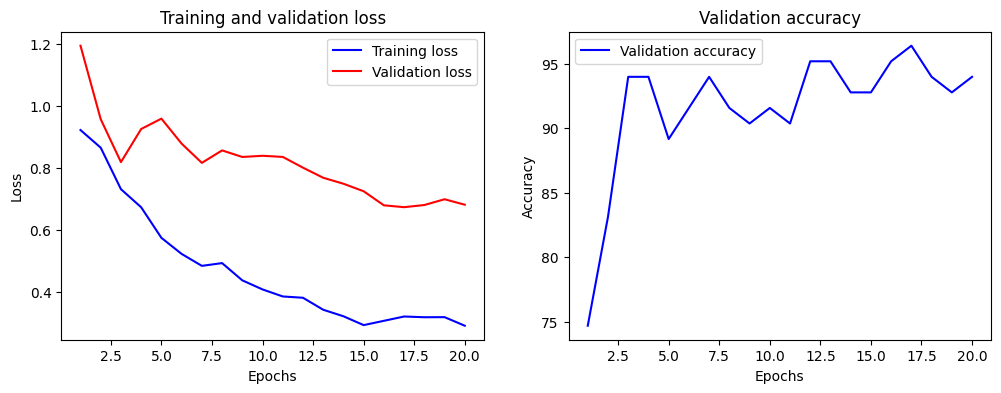

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

# Assuming standardized_data and y_one_hot are already defined
# Convert standardized_data and y_one_hot to PyTorch tensors
# standardized_data = torch.tensor(standardized_data, dtype=torch.float32)
# y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

# Reshape standardized_data to fit the CNN input requirements
# Reshape each sample to 2D (e.g., 480x1344)
# standardized_data = standardized_data.view(-1, 1, 480, 1344)

# Convert y_one_hot to class indices
y_indices = torch.argmax(y_one_hot, dim=1)

# Create a dataset and split it into training and testing sets
dataset = TensorDataset(standardized_data, y_indices)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 120 * 336, 128)  # Updated input size
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 9)  # Assuming y is one-hot encoded with 9 classes
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 120 * 336)  # Updated view size
        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

model = CNNModel()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Further reduced learning rate and added L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR by half every 5 epochs

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Path to save the best model
model_path = './Models/best_model.pth'

# Load the best model parameters if available
try:
    load_model(model, model_path)
    print("Loaded the best model parameters.")
except FileNotFoundError:
    print("No saved model found. Starting training from scratch.")

# Train the model
num_epochs = 20
best_accuracy = 0.0

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_x)
        
        # Compute the loss
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    # Step the scheduler
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')
    
    # Evaluate the model on the test set
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            predicted_classes = torch.argmax(outputs, dim=1)
            correct_predictions += (predicted_classes == batch_y).sum().item()
            total_predictions += batch_x.size(0)
    
    val_losses.append(val_loss / len(test_loader))
    accuracy = correct_predictions / total_predictions * 100
    val_accuracies.append(accuracy)
    
    print(f"Accuracy on test set: {accuracy:.2f}%")
    
    # Save the model if it has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        save_model(model, model_path)
        print("Saved the best model parameters.")

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Using K-fold Cross Validation to make sure that the model generalizes

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Assuming standardized_data and y_one_hot are already defined
# Convert standardized_data and y_one_hot to PyTorch tensors
# standardized_data = torch.tensor(standardized_data, dtype=torch.float32)
# y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

# Reshape standardized_data to fit the CNN input requirements
# Reshape each sample to 2D (e.g., 480x1344)
# standardized_data = standardized_data.view(-1, 1, 480, 1344)

# Convert y_one_hot to class indices
y_indices = torch.argmax(y_one_hot, dim=1)

# Create a dataset
dataset = TensorDataset(standardized_data, y_indices)

# Split the dataset into training+validation and test sets
test_size = int(0.2 * len(dataset))
train_val_size = len(dataset) - test_size
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 120 * 336, 128)  # Updated input size
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 9)  # Assuming y is one-hot encoded with 9 classes
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 120 * 336)  # Updated view size
        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Path to save the best model
model_path = './Models/test_model.pth'

# K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    
    # Create data loaders for training and validation sets
    train_subset = Subset(train_val_dataset, train_idx)
    val_subset = Subset(train_val_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    
    # Initialize the model, optimizer, and scheduler
    model = CNNModel()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_x)
            
            # Compute the loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        
        # Step the scheduler
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')
        
        # Evaluate the model on the training set
        model.eval()
        train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                train_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_train_predictions += (predicted_classes == batch_y).sum().item()
                total_train_predictions += batch_x.size(0)
        
        train_accuracy = correct_train_predictions / total_train_predictions * 100
        train_accuracies.append(train_accuracy)
        
        print(f"Accuracy on training set: {train_accuracy:.2f}%")
        
        # Evaluate the model on the validation set
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_predictions += (predicted_classes == batch_y).sum().item()
                total_predictions += batch_x.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        accuracy = correct_predictions / total_predictions * 100
        val_accuracies.append(accuracy)
        
        print(f"Accuracy on validation set: {accuracy:.2f}%")
        
        # Save the model if it has the best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_model(model, model_path)
            print("Saved the best model parameters.")

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

# Evaluate the model on the test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()
test_loss = 0
correct_test_predictions = 0
total_test_predictions = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        predicted_classes = torch.argmax(outputs, dim=1)
        correct_test_predictions += (predicted_classes == batch_y).sum().item()
        total_test_predictions += batch_x.size(0)

test_accuracy = correct_test_predictions / total_test_predictions * 100
print(f"Accuracy on test set: {test_accuracy:.2f}%")

# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Fold 1/5
Epoch [1/20], Loss: 2.2281
Accuracy on training set: 13.96%
Accuracy on validation set: 8.96%
Saved the best model parameters.
Epoch [2/20], Loss: 2.1677
Accuracy on training set: 23.40%
Accuracy on validation set: 5.97%
Epoch [3/20], Loss: 2.1320
Accuracy on training set: 25.66%
Accuracy on validation set: 7.46%
Epoch [4/20], Loss: 2.0826
Accuracy on training set: 27.55%
Accuracy on validation set: 7.46%


KeyboardInterrupt: 

## Todo modify the architecture of the model

In [116]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np
from sklearn.model_selection import KFold
import torch.optim as optim

# Assuming y_one_hot and standardized_data are already defined
# Convert y_one_hot to PyTorch tensor
# y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

# Reshape standardized_data to fit the CNN input requirements
# Reshape each sample to (batch_size, in_channels, sequence_length)
# standardized_data = torch.tensor(standardized_data, dtype=torch.float32).view(414, 84, 7680)

# Convert y_one_hot to class indices
# y_indices = torch.argmax(y_one_hot, dim=1)

# Create a dataset
dataset = TensorDataset(standardized_data, y_indices)

# Define the CNN model
class EEGCNNModel(nn.Module):
    def __init__(self):
        super(EEGCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=84, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(512)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 960, 1024)  # Adjust input size based on pooling
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 9)  # Assuming 9 classes for classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 512 * 960)  # Adjust view size based on pooling
        x = torch.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn6(self.fc3(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn7(self.fc4(x)))
        x = self.fc5(x)
        return x

# Define the loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGCNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Increased weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=10, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        torch.save(model.state_dict(), path)

# Training loop with early stopping
early_stopping = EarlyStopping(patience=10, delta=0.01)
num_epochs = 30  # Increased number of epochs

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Path to save the best model
model_path = './Models/imf_data_cnn.pth'

# K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    model = EEGCNNModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}')
        
        model.eval()
        train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                train_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_train_predictions += (predicted_classes == batch_y).sum().item()
                total_train_predictions += batch_x.size(0)
        
        train_accuracy = correct_train_predictions / total_train_predictions * 100
        train_accuracies.append(train_accuracy)
        
        print(f"Accuracy on training set: {train_accuracy:.2f}%")
        
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_predictions += (predicted_classes == batch_y).sum().item()
                total_predictions += batch_x.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        accuracy = correct_predictions / total_predictions * 100
        val_accuracies.append(accuracy)

        print(f'Validation Loss: {val_losses[-1]:.4f}')
        
        print(f"Accuracy on validation set: {accuracy:.2f}%\n")
        
        early_stopping(val_loss, model, model_path)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

Fold 1/5
Epoch [1/30], Training Loss: 2.2448
Accuracy on training set: 12.99%
Validation Loss: 3.9955
Accuracy on validation set: 9.64%

Epoch [2/30], Training Loss: 2.2346
Accuracy on training set: 12.69%
Validation Loss: 4.2240
Accuracy on validation set: 10.84%

Epoch [3/30], Training Loss: 2.1875
Accuracy on training set: 12.99%
Validation Loss: 3.3970
Accuracy on validation set: 13.25%

Epoch [4/30], Training Loss: 2.2029
Accuracy on training set: 11.78%
Validation Loss: 3.0566
Accuracy on validation set: 12.05%

Epoch [5/30], Training Loss: 2.1818
Accuracy on training set: 12.39%
Validation Loss: 3.0697
Accuracy on validation set: 18.07%

Epoch [6/30], Training Loss: 2.1805
Accuracy on training set: 12.39%
Validation Loss: 2.3602
Accuracy on validation set: 10.84%

Epoch [7/30], Training Loss: 2.1735
Accuracy on training set: 12.99%
Validation Loss: 2.5074
Accuracy on validation set: 10.84%

Epoch [8/30], Training Loss: 2.1452
Accuracy on training set: 13.60%
Validation Loss: 2.7

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\2952190570.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Loaded the best model parameters for final evaluation or further training.


### Below code is old model, not needed

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define the CNN model
class EEGCNNModel(nn.Module):
    def __init__(self):
        super(EEGCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=84, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(256 * 3840, 512)  # Adjust input size based on pooling
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 9)  # Assuming 9 classes for classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 256 * 3840)  # Adjust view size based on pooling
        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# Assuming standardized_data and y_indices are already defined
# standardized_data = torch.tensor(standardized_data, dtype=torch.float32)
# y_indices = torch.tensor(y_indices, dtype=torch.long)

# Create a dataset
dataset = TensorDataset(standardized_data, y_indices)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function, and optimizer
model = EEGCNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

#### Testing the model in best-model.pth on a general test data randomly sampled

In [35]:
len(X_imf.to_numpy()[0, 0])

7680

In [28]:
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np

# Load the best model parameters
model = CNNModel()
load_model(model, model_path)
model.eval()  # Set the model to evaluation mode

# Assuming standardized_data and y_one_hot are already defined and converted to tensors
# standardized_data = torch.tensor(standardized_data, dtype=torch.float32)
# y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)
y_indices = torch.argmax(y_one_hot, dim=1)

# Create a dataset
dataset = TensorDataset(standardized_data, y_indices)

# Split the dataset into training and test sets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Evaluate the model on the test dataset
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        predicted_classes = torch.argmax(outputs, dim=1)
        correct_predictions += (predicted_classes == batch_y).sum().item()
        total_predictions += batch_x.size(0)

test_accuracy = correct_predictions / total_predictions * 100
print(f"Accuracy on test dataset: {test_accuracy:.2f}%")

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\1827752004.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Accuracy on test dataset: 9.64%


## Modified CNN Architecture

In [40]:
X_imf_array = X_imf.to_numpy()

# Initialize an empty array to hold the reshaped data
reshaped_data = np.zeros((414, 84, 7680))

# Populate the reshaped_data array
for i in range(414):
    for j in range(84):
        reshaped_data[i, j, :] = X_imf_array[i, j]

# Convert the reshaped NumPy array to a PyTorch tensor
standardized_data = torch.tensor(reshaped_data, dtype=torch.float32)

# Normalize the data
mean = standardized_data.mean(dim=(0, 2), keepdim=True)
std = standardized_data.std(dim=(0, 2), keepdim=True)
standardized_data = (standardized_data - mean) / std

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# Assuming X_imf is already defined as a DataFrame
# Convert the DataFrame to a NumPy array
X_imf_array = X_imf.to_numpy()

# Initialize an empty array to hold the reshaped data
reshaped_data = np.zeros((414, 84, 7680))

# Populate the reshaped_data array
for i in range(414):
    for j in range(84):
        reshaped_data[i, j, :] = X_imf_array[i, j]

# Convert the reshaped NumPy array to a PyTorch tensor
standardized_data = torch.tensor(reshaped_data, dtype=torch.float32)

# Normalize each channel separately across the entire dataset
mean = standardized_data.mean(dim=(0, 2), keepdim=True)
std = standardized_data.std(dim=(0, 2), keepdim=True)
standardized_data = (standardized_data - mean) / std

# Assuming y_one_hot is already defined
# Convert y_one_hot to PyTorch tensor
y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

# Reshape standardized_data to fit the CNN input requirements
# Reshape each sample to (batch_size, in_channels, sequence_length)
standardized_data = standardized_data.view(414, 84, 7680)

# Convert y_one_hot to class indices
y_indices = torch.argmax(y_one_hot, dim=1)

# Create a dataset
dataset = TensorDataset(standardized_data, y_indices)

# Define the CNN model with increased dropout
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=84, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(256 * 1920, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 9)
        self.dropout = nn.Dropout(0.7)  # Increased dropout rate

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 256 * 1920)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# Define the loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)  # Increased weight decay

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        torch.save(model.state_dict(), path)

# Training loop with early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01)
num_epochs = 20

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Path to save the best model
model_path = './Models/test_model.pth'

# K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    
    model = CNNModel()
    optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')
        
        model.eval()
        train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                train_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_train_predictions += (predicted_classes == batch_y).sum().item()
                total_train_predictions += batch_x.size(0)
        
        train_accuracy = correct_train_predictions / total_train_predictions * 100
        train_accuracies.append(train_accuracy)
        
        print(f"Accuracy on training set: {train_accuracy:.2f}%")
        
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_predictions += (predicted_classes == batch_y).sum().item()
                total_predictions += batch_x.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        accuracy = correct_predictions / total_predictions * 100
        val_accuracies.append(accuracy)
        
        print(f"Accuracy on validation set: {accuracy:.2f}%")
        
        early_stopping(val_loss, model, model_path)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\832631245.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)


Fold 1/5
Epoch [1/20], Loss: 2.2623
Accuracy on training set: 16.62%
Accuracy on validation set: 19.28%
Epoch [2/20], Loss: 2.2065
Accuracy on training set: 25.08%
Accuracy on validation set: 7.23%
Epoch [3/20], Loss: 2.2282
Accuracy on training set: 22.36%
Accuracy on validation set: 13.25%
Epoch [4/20], Loss: 2.1390
Accuracy on training set: 27.79%
Accuracy on validation set: 13.25%
Epoch [5/20], Loss: 2.1309
Accuracy on training set: 55.59%
Accuracy on validation set: 16.87%
Epoch [6/20], Loss: 2.1043
Accuracy on training set: 56.80%
Accuracy on validation set: 14.46%
Epoch [7/20], Loss: 2.0346
Accuracy on training set: 45.92%
Accuracy on validation set: 8.43%
Early stopping
Fold 2/5
Epoch [1/20], Loss: 2.2778
Accuracy on training set: 11.78%
Accuracy on validation set: 16.87%
Early stopping
Fold 3/5
Epoch [1/20], Loss: 2.2896
Accuracy on training set: 14.50%
Accuracy on validation set: 12.05%
Early stopping
Fold 4/5
Epoch [1/20], Loss: 2.3001
Accuracy on training set: 12.39%
Accura

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\832631245.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Loaded the best model parameters for final evaluation or further training.


#### The above model wasn't able to generalise for some reason maybe I have to change the learning rate or something

In [86]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import KFold

# Assuming X_imf is already defined as a DataFrame
# Convert the DataFrame to a NumPy array
X_imf_array = X_imf.to_numpy()

# Initialize an empty array to hold the reshaped data
reshaped_data = np.zeros((414, 84, 7680))

# Populate the reshaped_data array
for i in range(414):
    for j in range(84):
        reshaped_data[i, j, :] = X_imf_array[i, j]

# Convert the reshaped NumPy array to a PyTorch tensor
standardized_data = torch.tensor(reshaped_data, dtype=torch.float32)

# Normalize each channel separately across the entire dataset
# mean = standardized_data.mean(dim=(0, 2), keepdim=True)
# std = standardized_data.std(dim=(0, 2), keepdim=True)
# standardized_data = (standardized_data - mean) / std

# Assuming y_one_hot is already defined
# Convert y_one_hot to PyTorch tensor
y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

# Reshape standardized_data to fit the CNN input requirements
# Reshape each sample to (batch_size, in_channels, sequence_length)
standardized_data = standardized_data.view(414, 84, 7680)

# Convert y_one_hot to class indices
y_indices = torch.argmax(y_one_hot, dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create a dataset
dataset = TensorDataset(standardized_data, y_indices)

# Define the CNN model with increased dropout
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=84, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512 * 960, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 9)
        self.dropout = nn.Dropout(0.3)  # Increased dropout rate

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Ensure the batch size is preserved
        # x = x.view(-1, 512 * 960)
        x = torch.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        return x

# Define the loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)  # Increased weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Implement early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        torch.save(model.state_dict(), path)

# Training loop with early stopping
early_stopping = EarlyStopping(patience=5, delta=0.001)
num_epochs = 30

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Path to save the best model
model_path = './Models/test_model.pth'

# K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    model = CNNModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}')
        
        model.eval()
        train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                train_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_train_predictions += (predicted_classes == batch_y).sum().item()
                total_train_predictions += batch_x.size(0)
        
        train_accuracy = correct_train_predictions / total_train_predictions * 100
        train_accuracies.append(train_accuracy)
        
        print(f"Accuracy on training set: {train_accuracy:.2f}%")
        
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_predictions += (predicted_classes == batch_y).sum().item()
                total_predictions += batch_x.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        accuracy = correct_predictions / total_predictions * 100
        val_accuracies.append(accuracy)

        print(f'Validation Loss: {val_losses[-1]:.4f}')
        
        print(f"Accuracy on validation set: {accuracy:.2f}%\n")
        
        early_stopping(val_loss, model, model_path)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\2111946378.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)


Fold 1/5
Epoch [1/30], Training Loss: 2.3128
Accuracy on training set: 14.50%
Validation Loss: 5.6926
Accuracy on validation set: 4.82%

Epoch [2/30], Training Loss: 2.3133
Accuracy on training set: 12.69%
Validation Loss: 2.6821
Accuracy on validation set: 7.23%

Epoch [3/30], Training Loss: 2.2984
Accuracy on training set: 12.99%
Validation Loss: 2.2385
Accuracy on validation set: 6.02%

Epoch [4/30], Training Loss: 2.2263
Accuracy on training set: 12.99%
Validation Loss: 2.2197
Accuracy on validation set: 8.43%

Epoch [5/30], Training Loss: 2.1487
Accuracy on training set: 12.39%
Validation Loss: 2.2876
Accuracy on validation set: 7.23%

Epoch [6/30], Training Loss: 2.1321
Accuracy on training set: 12.39%
Validation Loss: 2.2866
Accuracy on validation set: 7.23%

Epoch [7/30], Training Loss: 2.0732
Accuracy on training set: 12.39%
Validation Loss: 2.3295
Accuracy on validation set: 6.02%

Epoch [8/30], Training Loss: 2.0530
Accuracy on training set: 13.90%
Validation Loss: 2.3205
Ac

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\2111946378.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Loaded the best model parameters for final evaluation or further training.


In [ ]:
# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Trying out with RNN (LSTM layers)

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch.optim as optim

# Assuming X_imf and y_one_hot are already defined
# Convert the DataFrame to a NumPy array
X_imf_array = X_imf.to_numpy()

# Initialize an empty array to hold the reshaped data
reshaped_data = np.zeros((414, 84, 7680))

# Populate the reshaped_data array
for i in range(414):
    for j in range(84):
        reshaped_data[i, j, :] = X_imf_array[i, j]

# Convert the reshaped NumPy array to a PyTorch tensor
standardized_data = torch.tensor(reshaped_data, dtype=torch.float32)

# Normalize each channel separately across the entire dataset
mean = standardized_data.mean(dim=(0, 2), keepdim=True)
std = standardized_data.std(dim=(0, 2), keepdim=True)
standardized_data = (standardized_data - mean) / std

# Convert y_one_hot to PyTorch tensor
y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

# Reshape standardized_data to fit the RNN input requirements
# Reshape each sample to (batch_size, sequence_length, input_size)
standardized_data = standardized_data.view(414, 84, 7680)

# Convert y_one_hot to class indices
y_indices = torch.argmax(y_one_hot, dim=1)

# Create a dataset
dataset = TensorDataset(standardized_data, y_indices)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Path to save the best model
model_path = './Models/test_model.pth'

# K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

input_size = 7680
hidden_size = 256
num_layers = 2
num_classes = 9
num_epochs = 10

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    
    # Create data loaders for training and validation sets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # Initialize the model, optimizer, and scheduler
    model = RNNModel(input_size, hidden_size, num_layers, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_x)
            
            # Compute the loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        
        # Step the scheduler
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}')
        
        # Evaluate the model on the training set
        model.eval()
        train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                train_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_train_predictions += (predicted_classes == batch_y).sum().item()
                total_train_predictions += batch_x.size(0)
        
        train_accuracy = correct_train_predictions / total_train_predictions * 100
        train_accuracies.append(train_accuracy)
        
        print(f"Accuracy on training set: {train_accuracy:.2f}%")
        
        # Evaluate the model on the validation set
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_predictions += (predicted_classes == batch_y).sum().item()
                total_predictions += batch_x.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        accuracy = correct_predictions / total_predictions * 100
        val_accuracies.append(accuracy)

        print(f'Validation Loss: {val_losses[-1]:.4f}')
        
        print(f"Accuracy on validation set: {accuracy:.2f}%")
        
        # Save the model if it has the best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_model(model, model_path)
            print("Saved the best model parameters.")

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\3981922237.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)


Fold 1/5
Epoch [1/10], Training Loss: 2.1990
Accuracy on training set: 19.34%
Validation Loss: 2.2044
Accuracy on validation set: 10.84%
Saved the best model parameters.
Epoch [2/10], Training Loss: 2.1704
Accuracy on training set: 25.08%
Validation Loss: 2.2134
Accuracy on validation set: 10.84%
Epoch [3/10], Training Loss: 2.1369
Accuracy on training set: 29.31%
Validation Loss: 2.2329
Accuracy on validation set: 10.84%
Epoch [4/10], Training Loss: 2.0620
Accuracy on training set: 38.97%
Validation Loss: 2.2846
Accuracy on validation set: 8.43%
Epoch [5/10], Training Loss: 1.8759
Accuracy on training set: 47.43%
Validation Loss: 2.4452
Accuracy on validation set: 12.05%
Saved the best model parameters.
Epoch [6/10], Training Loss: 1.6108
Accuracy on training set: 59.82%
Validation Loss: 2.5793
Accuracy on validation set: 10.84%
Epoch [7/10], Training Loss: 1.3444
Accuracy on training set: 68.58%
Validation Loss: 2.7193
Accuracy on validation set: 12.05%
Epoch [8/10], Training Loss: 1

KeyboardInterrupt: 

#### More complex RNN

Fold 1/5
Epoch [1/10], Training Loss: 2.4521
Accuracy on training set: 17.82%
Validation Loss: 2.1968
Accuracy on validation set: 12.05%
Saved the best model parameters.
Epoch [2/10], Training Loss: 1.9662
Accuracy on training set: 29.00%
Validation Loss: 2.1967
Accuracy on validation set: 16.87%
Saved the best model parameters.
Epoch [3/10], Training Loss: 1.8557
Accuracy on training set: 40.79%
Validation Loss: 2.1968
Accuracy on validation set: 15.66%
Epoch [4/10], Training Loss: 1.6370
Accuracy on training set: 46.83%
Validation Loss: 2.1965
Accuracy on validation set: 20.48%
Saved the best model parameters.
Epoch [5/10], Training Loss: 1.6244
Accuracy on training set: 56.50%
Validation Loss: 2.1976
Accuracy on validation set: 16.87%
Epoch [6/10], Training Loss: 1.5514
Accuracy on training set: 58.31%
Validation Loss: 2.1991
Accuracy on validation set: 18.07%
Epoch [7/10], Training Loss: 1.5184
Accuracy on training set: 63.75%
Validation Loss: 2.2010
Accuracy on validation set: 16.

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\820576789.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

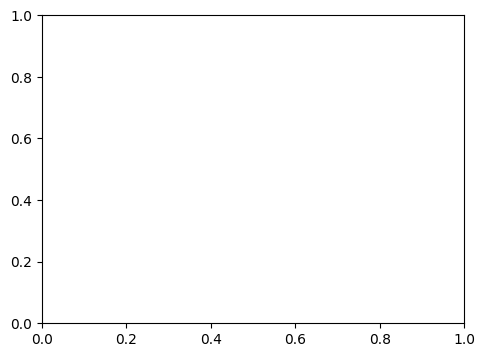

In [75]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, 1))

    def forward(self, lstm_output):
        attention_scores = torch.matmul(lstm_output, self.attention_weights).squeeze(-1)
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=1)
        weighted_sum = torch.bmm(attention_weights.unsqueeze(1), lstm_output).squeeze(1)
        return weighted_sum

class ComplexRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ComplexRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        attn_out = self.attention(lstm_out)
        out = self.fc1(attn_out)
        out = self.bn(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Define the model, optimizer, and criterion
hidden_size = 512
num_layers = 1
num_classes = 9
model = ComplexRNNModel(input_size, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=5*1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    
    # Create data loaders for training and validation sets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    
    # Initialize the model, optimizer, and scheduler
    model = ComplexRNNModel(input_size, hidden_size, num_layers, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=5*1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_x)
            
            # Compute the loss
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        
        # Step the scheduler
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}')
        
        # Evaluate the model on the training set
        model.eval()
        train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                train_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_train_predictions += (predicted_classes == batch_y).sum().item()
                total_train_predictions += batch_x.size(0)
        
        train_accuracy = correct_train_predictions / total_train_predictions * 100
        train_accuracies.append(train_accuracy)
        
        print(f"Accuracy on training set: {train_accuracy:.2f}%")
        
        # Evaluate the model on the validation set
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_predictions += (predicted_classes == batch_y).sum().item()
                total_predictions += batch_x.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        accuracy = correct_predictions / total_predictions * 100
        val_accuracies.append(accuracy)

        print(f'Validation Loss: {val_losses[-1]:.4f}')
        
        print(f"Accuracy on validation set: {accuracy:.2f}%")
        
        # Save the model if it has the best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_model(model, model_path)
            print("Saved the best model parameters.")

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Simple model without attention

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\820576789.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)


Fold 1/5
Epoch [1/20], Training Loss: 2.2018
Accuracy on training set: 12.69%
Validation Loss: 2.2010
Accuracy on validation set: 7.23%
Saved the best model parameters.
Epoch [2/20], Training Loss: 2.1852
Accuracy on training set: 12.39%
Validation Loss: 2.2051
Accuracy on validation set: 8.43%
Saved the best model parameters.
Epoch [3/20], Training Loss: 2.1849
Accuracy on training set: 13.29%
Validation Loss: 2.2083
Accuracy on validation set: 7.23%
Epoch [4/20], Training Loss: 2.1758
Accuracy on training set: 16.31%
Validation Loss: 2.2086
Accuracy on validation set: 8.43%
Epoch [5/20], Training Loss: 2.1495
Accuracy on training set: 23.56%
Validation Loss: 2.2224
Accuracy on validation set: 8.43%
Early stopping triggered.
Fold 2/5
Epoch [1/20], Training Loss: 2.1996
Accuracy on training set: 11.78%
Validation Loss: 2.2139
Accuracy on validation set: 8.43%
Saved the best model parameters.
Epoch [2/20], Training Loss: 2.1908
Accuracy on training set: 11.78%
Validation Loss: 2.2128
Ac

C:\Users\DELL\AppData\Local\Temp\ipykernel_8416\820576789.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


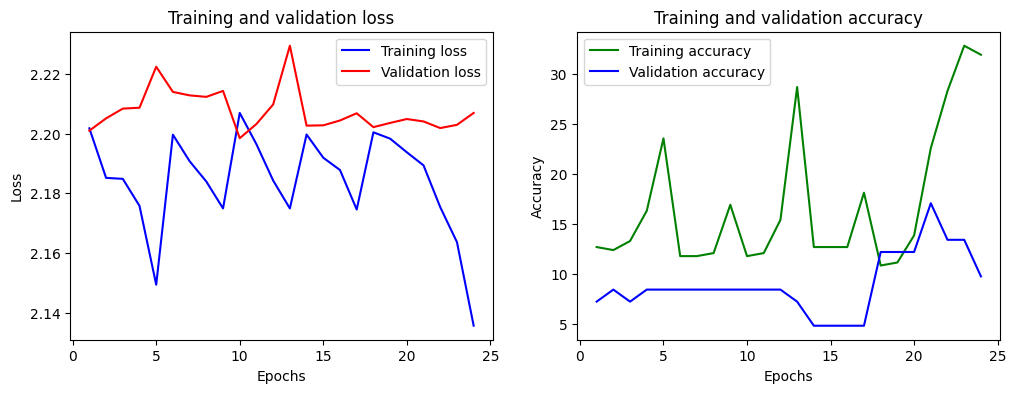

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_imf and y_one_hot are already defined
# Convert the DataFrame to a NumPy array
X_imf_array = X_imf.to_numpy()

# Initialize an empty array to hold the reshaped data
reshaped_data = np.zeros((414, 84, 7680))

# Populate the reshaped_data array
for i in range(414):
    for j in range(84):
        reshaped_data[i, j, :] = X_imf_array[i, j]

# Convert the reshaped NumPy array to a PyTorch tensor
standardized_data = torch.tensor(reshaped_data, dtype=torch.float32)

# Normalize each channel separately across the entire dataset
mean = standardized_data.mean(dim=(0, 2), keepdim=True)
std = standardized_data.std(dim=(0, 2), keepdim=True)
standardized_data = (standardized_data - mean) / std

# Convert y_one_hot to PyTorch tensor
y_one_hot = torch.tensor(y_one_hot, dtype=torch.float32)

# Reshape standardized_data to fit the RNN input requirements
standardized_data = standardized_data.view(414, 84, 7680)

# Convert y_one_hot to class indices
y_indices = torch.argmax(y_one_hot, dim=1)

# Create a dataset
dataset = TensorDataset(standardized_data, y_indices)

# Define the LSTM-based RNN model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=7680, hidden_size=128, num_layers=2, batch_first=True, dropout=0.5)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 9)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)
        c0 = torch.zeros(2, x.size(0), 128).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Path to save the best model
model_path = './Models/best_lstm_model.pth'

# K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    
    # Create data loaders for training and validation sets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # Initialize the model, optimizer, and scheduler
    model = LSTMModel()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    best_accuracy = 0.0
    patience = 3
    early_stopping_counter = 0
    
    for epoch in range(20):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/20], Training Loss: {train_losses[-1]:.4f}')
        
        # Evaluate the model on the training set
        model.eval()
        train_loss = 0
        correct_train_predictions = 0
        total_train_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in train_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                train_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_train_predictions += (predicted_classes == batch_y).sum().item()
                total_train_predictions += batch_x.size(0)
        
        train_accuracy = correct_train_predictions / total_train_predictions * 100
        train_accuracies.append(train_accuracy)
        
        print(f"Accuracy on training set: {train_accuracy:.2f}%")
        
        # Evaluate the model on the validation set
        val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                predicted_classes = torch.argmax(outputs, dim=1)
                correct_predictions += (predicted_classes == batch_y).sum().item()
                total_predictions += batch_x.size(0)
        
        val_losses.append(val_loss / len(val_loader))
        accuracy = correct_predictions / total_predictions * 100
        val_accuracies.append(accuracy)

        print(f'Validation Loss: {val_losses[-1]:.4f}')
        
        print(f"Accuracy on validation set: {accuracy:.2f}%")
        
        # Early stopping
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_model(model, model_path)
            print("Saved the best model parameters.")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model parameters for final evaluation or further training
load_model(model, model_path)
print("Loaded the best model parameters for final evaluation or further training.")

# Plotting the metrics
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()